# Performance Modeling

In [1]:
from os import makedirs
from os.path import join, isdir
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [2]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import markplotlib

In [4]:
from modules import load_xft
from modules import rank_models

### config paths

In [5]:
# plt.style.use("dark_background")
prodir = join("..", "data", "processed")
cleandir = join("..", "data", "clean")
plotdir = join("..", "plots", "score-modeling")

In [6]:
modeldir = join("..", "model-results")
if not isdir(modeldir):
    makedirs(modeldir)

## load data

In [7]:
emb = load_xft.load_embeddings(join(prodir, "embeddings", "embeddings.json"))
emb.sample(5)

,,,workoutDescription,workoutName,embedding,x,y,cluster
year,competitionType,workoutNumber,,,,,,
2012,open,4,Complete as many rounds and reps as possible i...,12.4,"[-0.020310973700000002, -0.026627522, -0.00272...",-9.851244,-0.992158,43
2009,games,1,7-k Hill Run\n,7K Hill Run,"[0.012520395200000001, -0.0324532762, -0.02437...",56.962162,2.135507,20
2020,games,13,Run along 3-mile± course through varying terra...,Ranch Loop,"[0.0049290722000000006, -0.0392468683, -0.0235...",52.799564,1.960351,20
2022,games,14,"For time:\n\n1,000-m row\n50 thrusters\n30 bar...","Games 2022, Event 14","[-0.0045113512, -0.0612166263, -0.0192162897, ...",0.703960,22.987808,1
2014,games,10,For time of:\n7 handstand push-ups (deficit fo...,Push Pull,"[-0.001013772, -0.0030393281, -0.0225017611, -...",15.446676,-0.593302,41


In [8]:
xft = load_xft.load_competition_results(
    join(cleandir, "competition_results.parquet"), 500
)
xft.sort_index(inplace=True)
xft.sample(10)

divisionNumber  gender  \
year competitionType workoutNumber divisionName                            
2020 open            5             Women (45-49)               4  female   
2024 open            3             Women (65+)                39  female   
2018 open            3             Women (45-49)               4  female   
2015 open            3             Men (40-44)                12    male   
2012 games           4             Women                       2  female   
     open            2             Women (45-49)               4  female   
2023 open            3             Women (40-44)              13  female   
2013 open            4             Women (45-49)               4  female   
2024 open            2             Men (60-64)                36    male   
2018 open            3             Men (45-49)                 3    male   

                                                    height     weight   age  \
year competitionType workoutNumber divisionName                               
2020 open            5             Women (45-49)  1.779999  70.000000  46.0   
2024 open            3             Women (65+)    1.577608  49.031998  65.0   
2018 open            3             Women (45-49)  1.674759  68.977280  45.0   
2015 open            3             Men (40-44)    1.755725  77.180000  43.0   
2012 games           4             Women          1.690002  68.961510  18.0   
     open            2             Women (45-49)  1.653944  58.565990  49.0   
2023 open            3             Women (40-44)  1.704834  62.197998  44.0   
2013 open            4             Women (45-49)  1.653944  59.020000  47.0   
2024 open            2             Men (60-64)    1.692413  70.413795  60.0   
2018 open            3             Men (45-49)    1.806617  88.530022  45.0   

                                                  workoutRank  overallRank  \
year competitionType workoutNumber divisionName                              
2020 open            5             Women (45-49)         65.0        144.0   
2024 open            3             Women (65+)          127.0        135.0   
2018 open            3             Women (45-49)        677.0        181.0   
2015 open            3             Men (40-44)          177.0        269.0   
2012 games           4             Women                 23.0         30.0   
     open            2             Women (45-49)        118.0        290.0   
2023 open            3             Women (40-44)        220.0         64.0   
2013 open            4             Women (45-49)        127.0        179.0   
2024 open            2             Men (60-64)          115.0        475.0   
2018 open            3             Men (45-49)          530.0        161.0   

                                                         r         o  \
year competitionType workoutNumber divisionName                        
2020 open            5             Women (45-49)  1.050977  0.495578   
2024 open            3             Women (65+)    0.477040  0.410915   
2018 open            3             Women (45-49) -0.885436  0.290415   
2015 open            3             Men (40-44)    0.392252 -0.161379   
2012 games           4             Women         -0.087552 -0.517724   
     open            2             Women (45-49)  0.070668 -0.393346   
2023 open            3             Women (40-44)  0.488776  1.056333   
2013 open            4             Women (45-49)  0.612685  0.251163   
2024 open            2             Men (60-64)    0.819289 -1.612762   
2018 open            3             Men (45-49)   -0.122037  0.400563   

                                                         h         w         a  
year competitionType workoutNumber divisionName                                 
2020 open            5             Women (45-49)  2.119488  1.236390 -0.315770  
2024 open            3             Women (65+)   -0.789866 -1.429817 -0.976308  
2018 open            3             Women (45-49)  0.455017  1.

In [9]:
xft.index.levels[-1]

Index(['Men', 'Men (35-39)', 'Men (40-44)', 'Men (45-49)', 'Men (50-54)',
       'Men (55-59)', 'Men (60+)', 'Men (60-64)', 'Men (65+)', 'Women',
       'Women (35-39)', 'Women (40-44)', 'Women (45-49)', 'Women (50-54)',
       'Women (55-59)', 'Women (60+)', 'Women (60-64)', 'Women (65+)'],
      dtype='object', name='divisionName')

## effects with univariate regressions

In [10]:
direct_effects = {}
for idx, g in xft.groupby(level=[0, 1, 2, 3]):
    g = g[["r", "w", "h", "a"]].dropna()
    y = g["r"].values
    direct_effects[idx] = {
        f"b_{x}": stats.linregress(g[x].values, y).slope for x in ("h", "w", "a")
    }
direct_effects = pd.DataFrame(direct_effects).T

In [11]:
direct_effects.to_csv(
    join(modeldir, "direct_effects.csv"),
    index_label=("year", "competitionType", "workoutNumber", "divisionName"),
)

## workout/event selection

In [12]:
year, competitionType, workoutNumber, divisionName = 2019, "open", 1, "Women"

## multiple regression for one division of one event

In [13]:
df = xft.loc[year, competitionType, 1, "Women"]
df

divisionNumber  gender  \
year competitionType workoutNumber divisionName                           
2019 open            1             Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
...                                                         ...     ...   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   
                                   Women                      2  female   

                                                   height     weight   age  \
year competitionType workoutNumber divisionName                              
2019 open            1             Women         1.790001  68.000000  26.0   
                                   Women         1.700000  69.007889  29.0   
                                   Women         1.699998  72.000000  24.0   
                                   Women         1.700001  61.290035  37.0   
                                   Women         1.729999  69.000000  26.0   
...                                                   ...        ...   ...   
                                   Women         1.577608  61.290009  31.0   
                                   Women         1.628498  66.283981  33.0   
                                   Women         1.625180  61.144073  26.0   
                                   Women         1.628498  62.969784  27.0   
                                   Women         1.570000  56.750000  31.0   

                                                 workoutRank  overallRank  \
year competitionType workoutNumber divisionName                             
2019 open            1             Women                 1.0        112.0   
                                   Women                 3.0          2.0   
                                   Women                 3.0         12.0   
                                   Women                 5.0         20.0   
                                   Women                 6.0          1.0   
...                                                      ...          ...   
                                   Women              3894.0        381.0   
                                   Women              4067.0        491.0   
                                   Women              4067.0        494.0   
                                   Women              4067.0        443.0   
                                   Women              4236.0        427.0   

                                                        r         o         h  \
year competitionType workoutNumber divisionName                                 
2019 open            1             Women         2.855875  0.726045  2.362032   
                                   Women         2.551384  2.628204  0.887423   
                                   Women         2.551384  1.947272  0.887390   
                                   Women         2.383103  1.717779  0.887441   
                                   Women         2.299806  2.855875  1.378940   
...                                                   ...       ...       ...   
                                   Women        -2.299806 -0.740120 -1.117907   
                                   Women        -2.487193 -2.116118 -0.284100   
                                   Women        -2.487193 -2.299806 -0.338465   
                                   Women        -2.487193 -1.229501 -0.284102   
                                   Women        -2.855875 -1.082636 -1.242570   

  

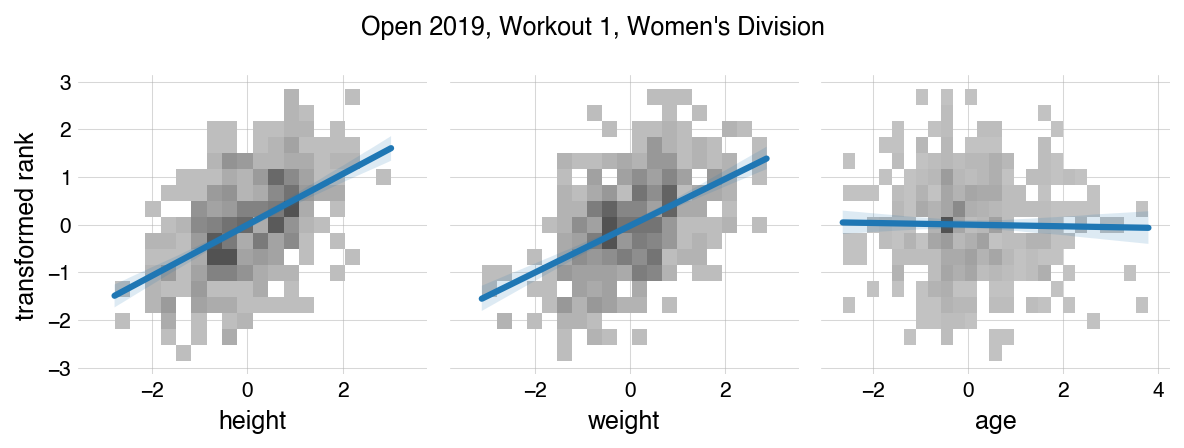

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
sns.histplot(df, x="h", y="r", color="gray", ax=axs[0])
sns.histplot(df, x="w", y="r", color="gray", ax=axs[1])
sns.histplot(df, x="a", y="r", color="gray", ax=axs[2])
sns.regplot(df, x="h", y="r", scatter=False, ax=axs[0])
sns.regplot(df, x="w", y="r", scatter=False, ax=axs[1])
sns.regplot(df, x="a", y="r", scatter=False, ax=axs[2])
for ax, label in zip(axs, ["height", "weight", "age"]):
    ax.axis("equal")
    ax.set_xlabel(label)
    ax.set_ylabel("transformed rank")
fig.suptitle("Open 2019, Workout 1, Women's Division")
fig.tight_layout()
fig.savefig("../plots/effects/open_women_2019.png")

<Axes: xlabel='r', ylabel='Count'>

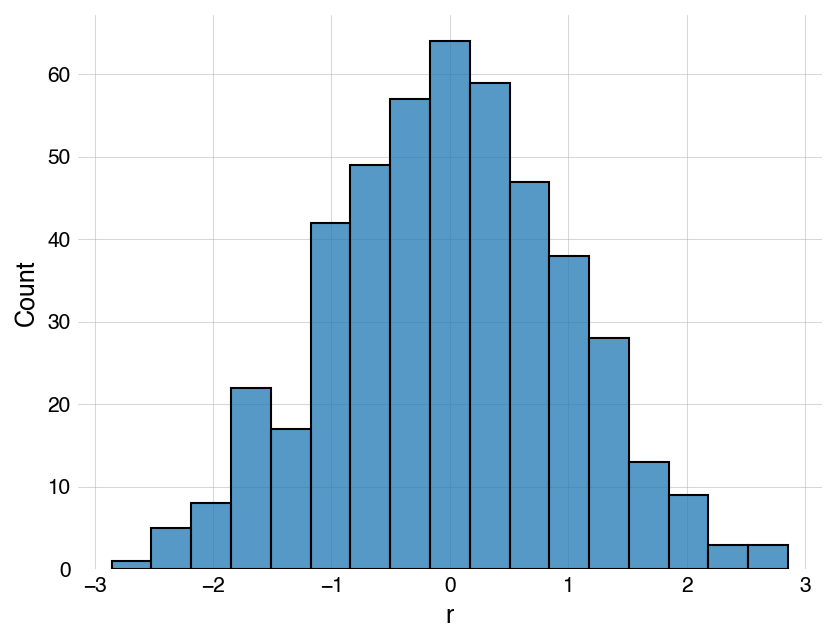

In [15]:
sns.histplot(df, x="r")

In [16]:
individual_division_model = rank_models.setup_division_regression(
    xft, year, competitionType, workoutNumber, divisionName
)

  465 records


In [17]:
df = xft.xs(key=(year, competitionType, workoutNumber, divisionName))
df = df[["r", "h", "w", "a"]].dropna()
df.shape

(465, 4)

In [18]:
sm.OLS(df.r.values, df[["h", "w", "a"]].values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.292
Model:                            OLS   Adj. R-squared (uncentered):              0.287
Method:                 Least Squares   F-statistic:                              63.42
Date:                Thu, 04 Apr 2024   Prob (F-statistic):                    2.35e-34
Time:                        15:13:55   Log-Likelihood:                         -573.47
No. Observations:                 465   AIC:                                      1153.
Df Residuals:                     462   BIC:                                      1165.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3591      0.055      6.545      0.000       0.251       0.467
x2             0.2599      0.054      4.829      0.000       0.154       0.366
x3            -0.0177      0.038     -0.462      0.644      -0.093       0.058
==============================================================================
Omnibus:                        0.392   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.280
Skew:                           0.053   Prob(JB):                        0.870
Kurtosis:                       3.055   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
with individual_division_model:
    post = pm.sample(cores=8, chains=8, tune=2_000, draws=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [a, b, sigma]


Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 3 seconds.


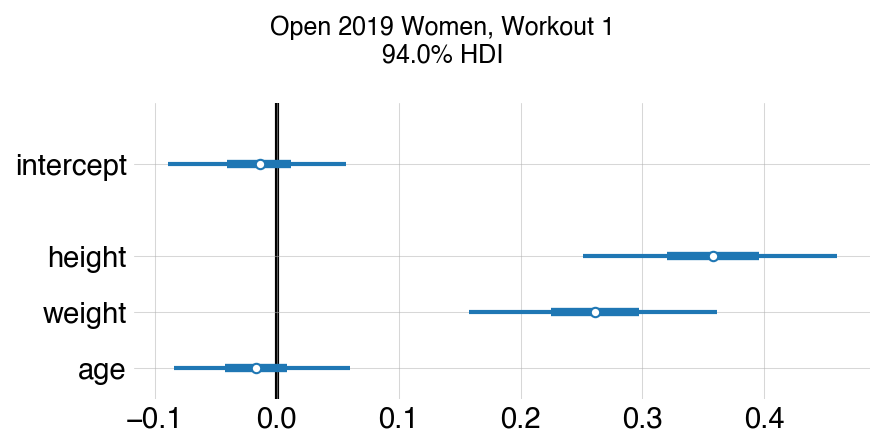

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
az.plot_forest(
    post,
    combined=True,
    var_names=["a", "b"],
    ax=ax,
)
ax.axvline(0, color="k", zorder=-1)
ax.grid(True)
ax.set_yticklabels(["age", "weight", "height", "intercept"])
fig.suptitle(
    f"{competitionType.title()} {year} {divisionName}, Workout {workoutNumber}\n{ax.get_title()}"
)
ax.set_title(None)
fig.tight_layout()

## hierarchical multiple regression for one event, using all divisions

In [21]:
xft.xs(key=(2021, "open")).reset_index().drop_duplicates(
    subset=("divisionName", "gender", "height", "weight", "age", "o")
)

,workoutNumber,divisionName,divisionNumber,gender,height,weight,age,workoutRank,overallRank,r,o,h,w,a
0,1,Men,1,male,1.710195,86.158005,26.0,1.0,14.0,2.851757,1.874442,-1.157643,-0.267556,-0.337288
1,1,Men,1,male,1.755723,82.690010,25.0,5.0,4.0,2.623793,2.378329,-0.371171,-0.773726,-0.581669
2,1,Men,1,male,1.753869,88.364403,22.0,6.0,57.0,2.482580,1.166337,-0.403207,0.054478,-1.314810
3,1,Men,1,male,1.730279,83.134079,25.0,8.0,30.0,2.378329,1.512390,-0.810712,-0.708912,-0.581669
4,1,Men,1,male,1.750000,84.968750,22.0,9.0,17.0,2.294895,1.787151,-0.470036,-0.441134,-1.314810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6560,1,Women (65+),39,female,1.577608,64.921997,65.0,729.0,232.0,-2.669141,-0.167735,-0.789862,0.586403,-0.976308
6561,1,Women (65+),39,female,1.577609,54.479988,76.0,729.0,332.0,-2.669141,-0.623687,-0.789857,-0.738543,3.103539
6562,1,Women (65+),39,female,1.577608,55.387993,67.0,729.0,396.0,-2.669141,-0.966171,-0.789864,-0.623330,-0.234517
6563,1,Women (65+),39,female,1.704834,64.468010,70.0,729.0,417.0,-2.669141,-1.128967,1.165688,0.528798,0.878168


In [22]:
model = rank_models.setup_event_regression(xft, 2021, "open", 1)

Men               459 records
Men (35-39)       455 records
Men (40-44)       453 records
Men (45-49)       436 records
Men (50-54)       456 records
Men (55-59)       432 records
Men (60-64)       444 records
Men (65+)         403 records
Women             455 records
Women (35-39)     409 records
Women (40-44)     405 records
Women (45-49)     405 records
Women (50-54)     390 records
Women (55-59)     368 records
Women (60-64)     329 records
Women (65+)       266 records


In [23]:
with model:
    post = pm.sample(cores=16, chains=16, tune=2_000, draws=2_000, target_accept=0.925)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]


Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 154 seconds.


In [24]:
var_names = list(
    filter(
        lambda c: "b" in c or c == "mu",  # or "correlation" in c or c == "stds",
        post.posterior.data_vars,
    )
)
var_names

['mu',
 'b Men',
 'b Men (35-39)',
 'b Men (40-44)',
 'b Men (45-49)',
 'b Men (50-54)',
 'b Men (55-59)',
 'b Men (60-64)',
 'b Men (65+)',
 'b Women',
 'b Women (35-39)',
 'b Women (40-44)',
 'b Women (45-49)',
 'b Women (50-54)',
 'b Women (55-59)',
 'b Women (60-64)',
 'b Women (65+)']

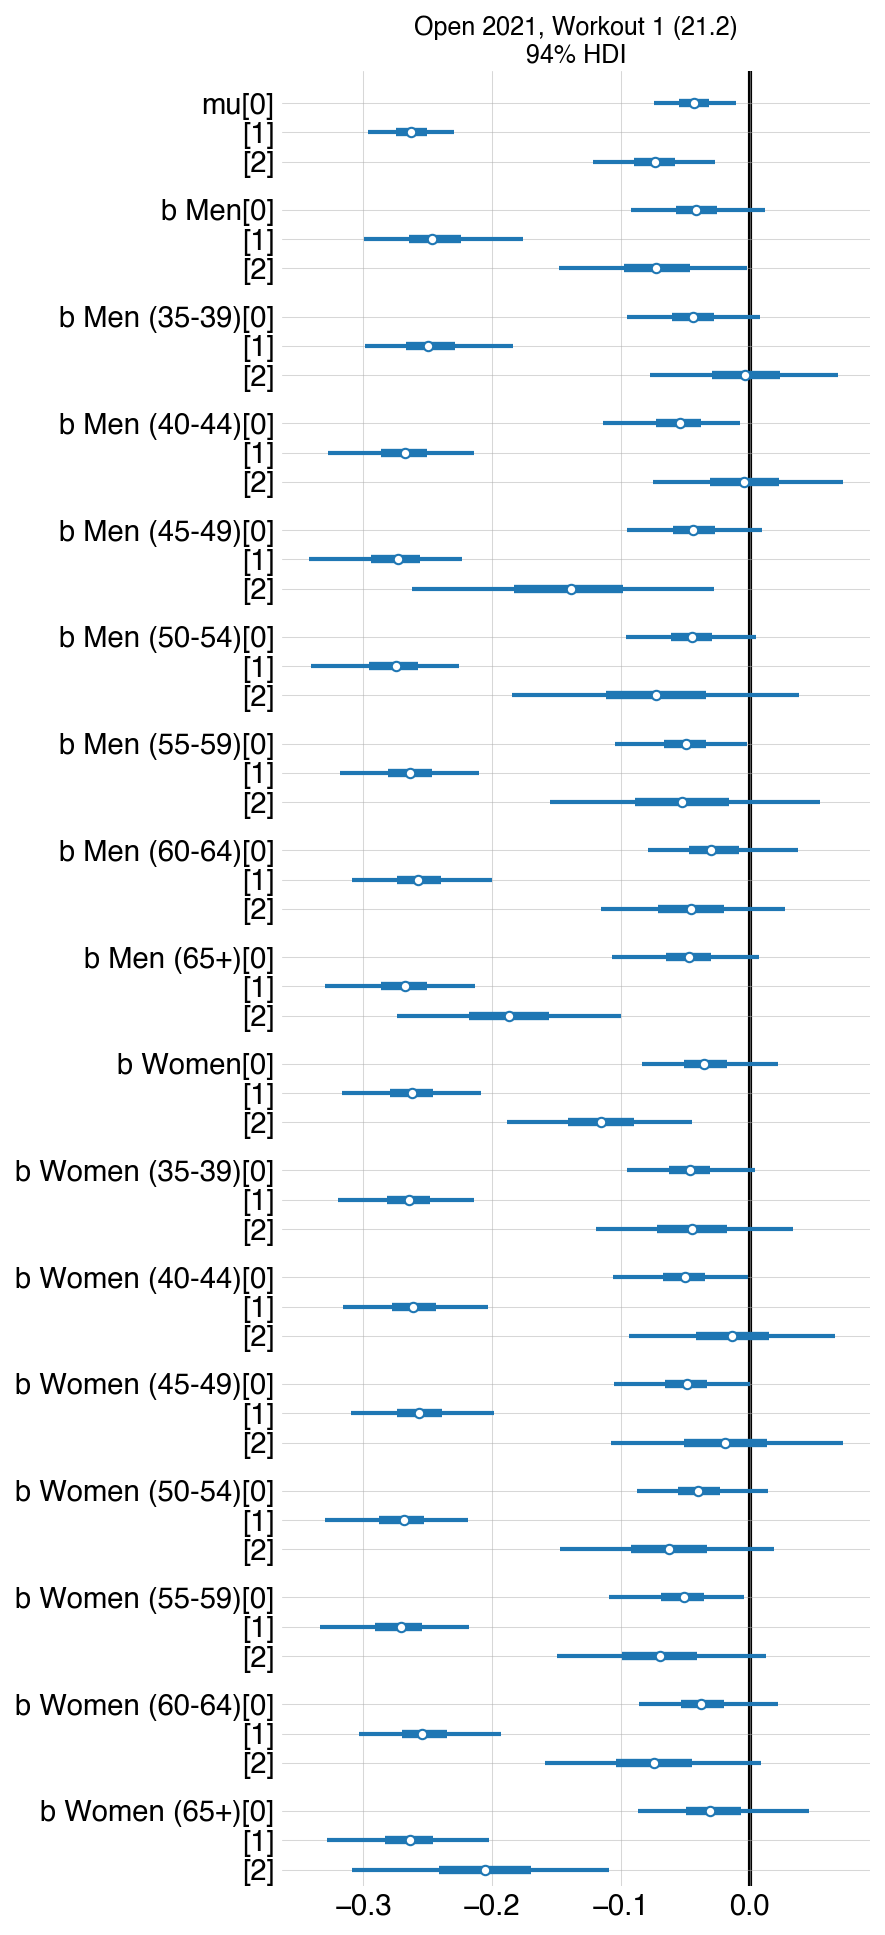

In [25]:
fig, ax = plt.subplots(figsize=(6, 13))
az.plot_forest(
    post.posterior,
    # [prior.prior, post.posterior],
    # model_names=["prior", "posterior"],
    var_names=var_names,
    combined=True,
    ax=ax,
)
ax.axvline(0, color="k", zorder=-1)
ax.grid(True)
ax.set_title("Open 2021, Workout 1 (21.2)\n94% HDI")
fig.tight_layout()

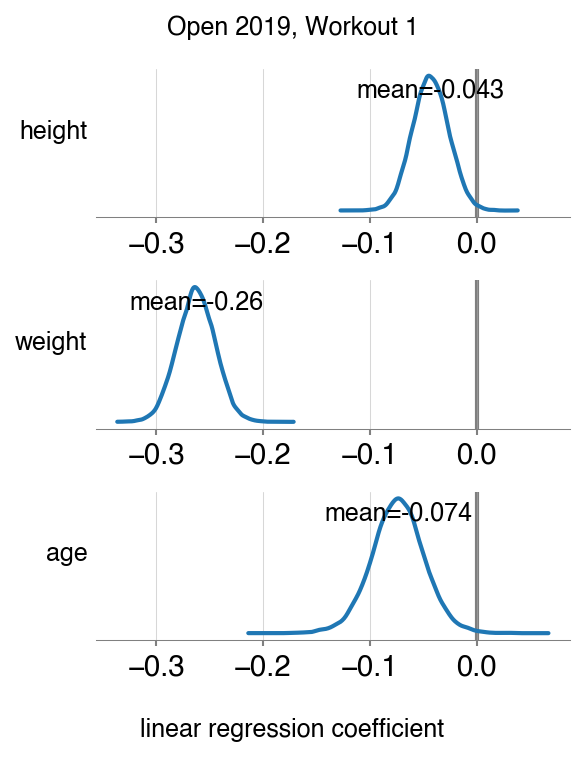

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(4, 5), sharex=True)
az.plot_posterior(post, var_names="mu", hdi_prob="hide", ax=axs)
for ax, label in zip(axs, ["height", "weight", "age"]):
    ax.axvline(0, color="k", alpha=0.5, zorder=-1)
    ax.set_ylabel(label, rotation=0, ha="right")
    ax.set_title(None)
fig.supxlabel("linear regression coefficient")
fig.suptitle(f"{competitionType.title()} {year}, Workout {workoutNumber}")
plt.gcf().tight_layout()

## hierarchical regression for the overall rankings in an event

In [27]:
df = (
    xft.xs(key=(2021, "open"))
    .droplevel(0)
    .drop_duplicates(subset=("gender", "height", "weight", "age", "o"))
)
df = df[["o", "h", "w", "a"]].dropna()
X = {}
y = {}
for d, g in df.groupby(level=0):
    print(f"{d:15} {len(g):5} records")
    X[d] = g[["h", "w", "a"]].values
    y[d] = g["o"].values
ndiv = len(X)

Men               459 records
Men (35-39)       455 records
Men (40-44)       453 records
Men (45-49)       435 records
Men (50-54)       456 records
Men (55-59)       432 records
Men (60-64)       444 records
Men (65+)         403 records
Women             455 records
Women (35-39)     409 records
Women (40-44)     405 records
Women (45-49)     405 records
Women (50-54)     390 records
Women (55-59)     368 records
Women (60-64)     329 records
Women (65+)       266 records


In [28]:
model = rank_models.setup_comp_regression(xft, 2023, "open")

Men               442 records
Men (35-39)       455 records
Men (40-44)       441 records
Men (45-49)       439 records
Men (50-54)       443 records
Men (55-59)       426 records
Men (60-64)       431 records
Men (65+)         427 records
Women             439 records
Women (35-39)     400 records
Women (40-44)     391 records
Women (45-49)     374 records
Women (50-54)     375 records
Women (55-59)     364 records
Women (60-64)     313 records
Women (65+)       285 records


In [29]:
with model:
    post = pm.sample(cores=16, chains=16, tune=2_000, draws=2_000, target_accept=0.925)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]


Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 139 seconds.


In [30]:
var_names = list(
    filter(
        lambda c: "b" in c or c == "mu",  # or "correlation" in c or c == "stds",
        post.posterior.data_vars,
    )
)
var_names

['mu',
 'b Men',
 'b Men (35-39)',
 'b Men (40-44)',
 'b Men (45-49)',
 'b Men (50-54)',
 'b Men (55-59)',
 'b Men (60-64)',
 'b Men (65+)',
 'b Women',
 'b Women (35-39)',
 'b Women (40-44)',
 'b Women (45-49)',
 'b Women (50-54)',
 'b Women (55-59)',
 'b Women (60-64)',
 'b Women (65+)']

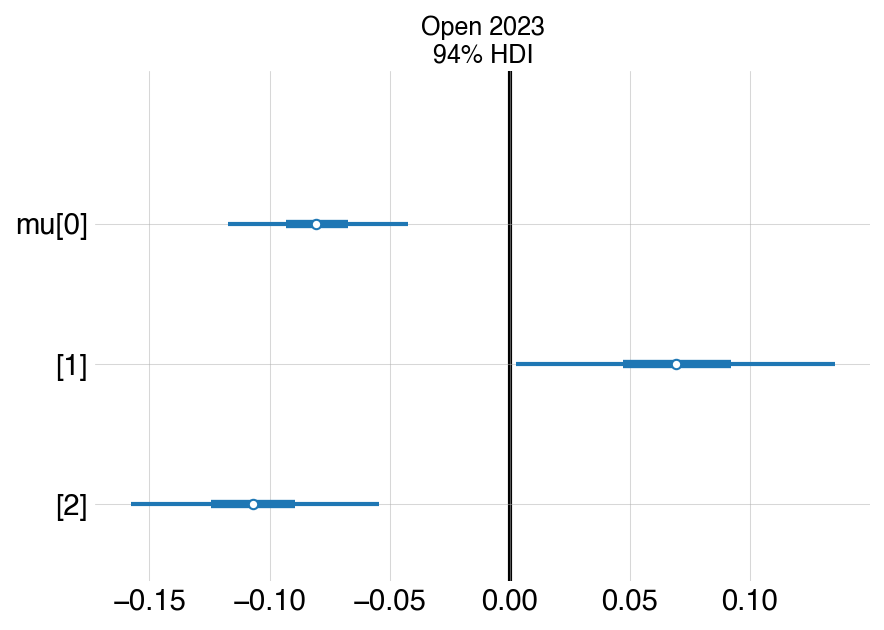

In [31]:
axs = az.plot_forest(
    post.posterior,
    var_names="mu",
    combined=True,
)
axs[0].axvline(0, color="k", zorder=-1)
axs[0].grid(True)
axs[0].set_title("Open 2023\n94% HDI")
plt.gcf().tight_layout()

## several hierarchical regressions for different events

In [32]:
keys = [
    (2024, "open", 1),
    (2024, "open", 2),
    (2024, "open", 3),
]

In [33]:
posteriors = []
for key in keys:
    model = rank_models.setup_event_regression(xft, *key, silent=True)
    with model:
        posteriors.append(
            pm.sample(
                cores=16,
                chains=16,
                tune=2_000,
                draws=2_000,
                target_accept=0.925,
                progressbar=False,
            )
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 108 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 166 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu, LKJ, B_, intercept, sigma]
Sampling 16 chains for 2_000 tune and 2_000 draw iterations (32_000 + 32_000 draws total) took 144 seconds.


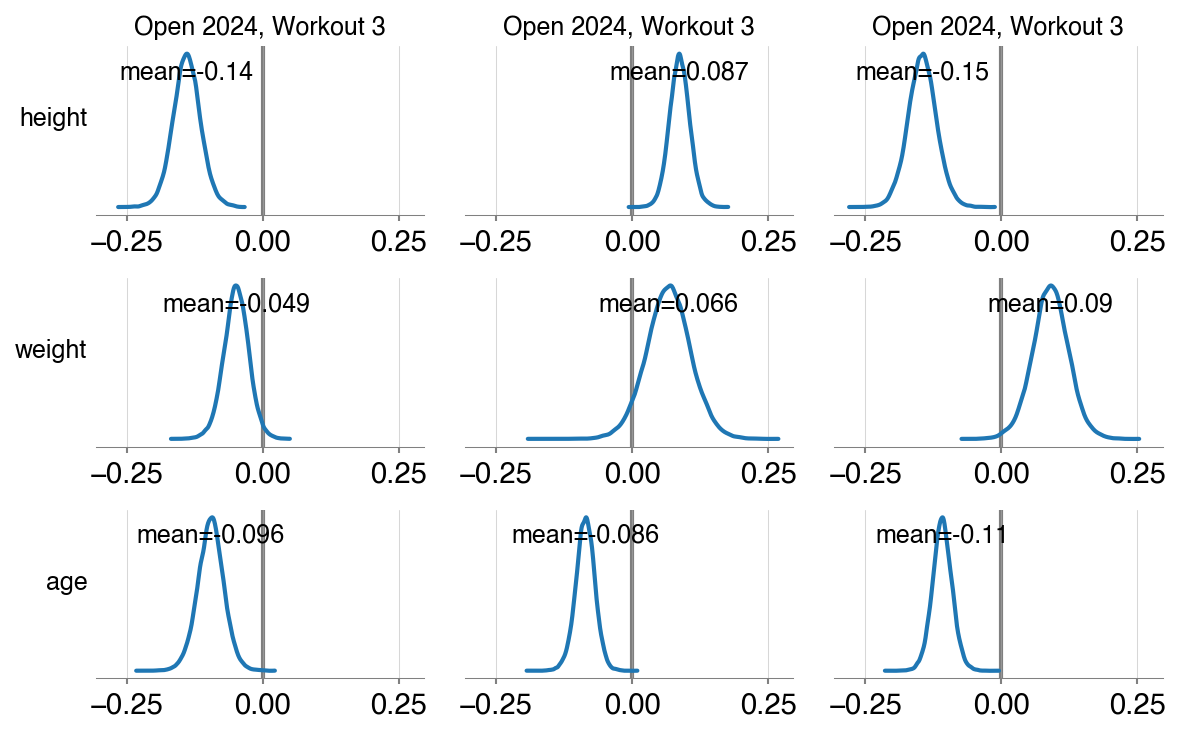

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(8, 5), sharex=True)
for i in range(3):
    az.plot_posterior(posteriors[i], var_names="mu", hdi_prob="hide", ax=axs[:, i])
for ax in axs.flatten():
    ax.axvline(0, color="k", alpha=0.5, zorder=-1)
    ax.set_title(None)
for ax, label in zip(axs[:, 0], ["height", "weight", "age"]):
    ax.set_ylabel(label, rotation=0, ha="right")
for j in range(3):
    key = keys[i]
    axs[0, j].set_title(f"{key[1].title()} {key[0]}, Workout {key[2]}", fontsize=12)
fig.tight_layout()

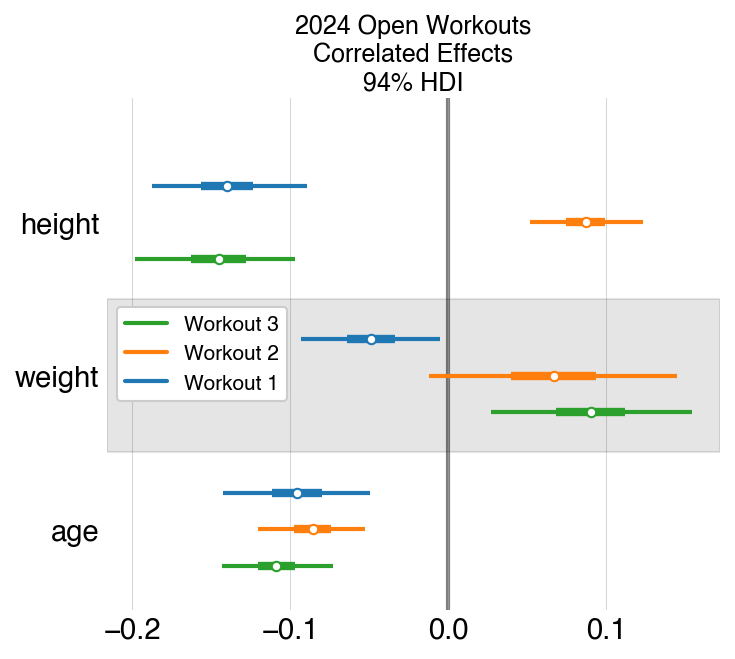

In [35]:
fig, ax = plt.subplots(figsize=(5, 4.5))
az.plot_forest(
    posteriors,
    model_names=["Workout 1", "Workout 2", "Workout 3"],
    var_names=["mu"],
    combined=True,
    ax=ax,
)
ax.axvline(0, color="k", alpha=0.5, zorder=-1)
ax.set_yticklabels(["age", "weight", "height"])
ax.set_title("2024 Open Workouts\nCorrelated Effects\n94% HDI")
fig.tight_layout()